In [27]:
import networkx as nx
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
def simulate_SIS(G, beta, mu, infected_init, steps=200):
    """
        Simula o modelo SIS na rede G por um número fixo de passos, retornando
        a fração de vértices infectados ao longo do tempo.

        Parâmetros:
            G (networkx.Graph): grafo da rede.
            beta (float): probabilidade de infecção.
            mu (float): probabilidade de recuperação.
            infected_init (iterable): vértices inicialmente infectados.
            steps (int): número de passos da simulação.

        Retorna:
            list: série temporal da fração de vértices infectados.
    """
    infected = set(infected_init)

    history = []

    for _ in range(steps):
        new_infected = set(infected)

        for v in list(infected):
            # recuperação
            if random.random() < mu:
                new_infected.remove(v)

        for v in list(infected):
            for u in G.neighbors(v):
                if u not in new_infected and random.random() < beta:
                    new_infected.add(u)

        infected = new_infected
        history.append(len(infected) / G.number_of_nodes())

    return history


def epidemic_persists(history, threshold=0.01):
    """
        Verifica se a epidemia se fixou avaliando a média dos últimos passos da série.

        Parâmetros:
            history (list): fração de infectados ao longo da simulação.
            threshold (float): limiar mínimo para considerar persistência.

        Retorna:
            bool: True se a epidemia se mantém acima do limiar, False caso contrário.
    """
    return np.mean(history[-50:]) > threshold

## Configurações

In [ ]:
N = 10000
m = 10
G = nx.barabasi_albert_graph(N, m)

beta = 0.01
mu = 0.1

In [39]:
deg_list = np.array([d for _, d in G.degree()])
emp_k = deg_list.mean()
print(f"Rede criada: N={N}, k médio={emp_k:.2f}")

Rede criada: N=10000, k médio=19.98


## Questão 03 - A

In [30]:
def test_fraction_random(G, p, beta, mu, runs=50):
    """
        Remove aleatoriamente uma fração p de vértices e testa se a 
        epidemia se fixa após várias simulações.
        
        Parâmetros:
            G (networkx.Graph): grafo da rede.
            p (float): fração de vértices imunizados aleatoriamente.
            beta (float): taxa de infecção.
            mu (float): taxa de recuperação.
            runs (int): número de simulações independentes.
        
        Retorna:
            float: fração de simulações em que a epidemia se mantém endêmica.
    """
    N = G.number_of_nodes()
    num_remove = int(p * N)
    remove = random.sample(list(G.nodes()), num_remove)

    G2 = G.copy()
    G2.remove_nodes_from(remove)

    survives = 0
    for _ in range(runs):
        infected_init = random.sample(list(G2.nodes()), 5)
        hist = simulate_SIS(G2, beta, mu, infected_init)
        if epidemic_persists(hist):
            survives += 1

    return survives / runs


ps = np.linspace(0, 0.5, 20)
results_a = []

for p in tqdm(ps):
    results_a.append(test_fraction_random(G, p, beta, mu))

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [14:03<00:00, 42.15s/it]


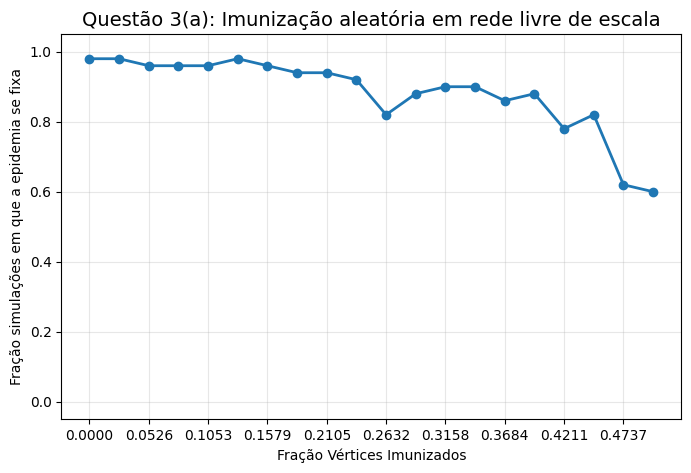

In [31]:
plt.figure(figsize=(8,5))
plt.plot(ps, results_a, marker='o', linewidth=2)
plt.xlabel("Fração Vértices Imunizados", fontsize=10)
plt.ylabel("Fração simulações em que a epidemia se fixa", fontsize=10)
plt.title("Questão 3(a): Imunização aleatória em rede livre de escala", fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(ps[::2])
plt.ylim(-0.05, 1.05)
plt.show()

## Questão 3 - B

In [32]:
degree_list = sorted(G.degree(), key=lambda x: x[1], reverse=True)
nodes_by_degree = [v for v, d in degree_list]

def test_fraction_hubs(G, p, beta, mu, runs=50):
    """
        Remove a fração p dos vértices de maior grau e testa se a 
        epidemia se fixa após várias simulações.
        
        Parâmetros:
            G (networkx.Graph): grafo da rede.
            p (float): fração de hubs a serem imunizados (maiores graus).
            beta (float): taxa de infecção.
            mu (float): taxa de recuperação.
            runs (int): número de simulações independentes.
        
        Retorna:
            float: fração de simulações em que a epidemia se mantém endêmica.
    """
    N = G.number_of_nodes()
    num_remove = int(p * N)

    remove = nodes_by_degree[:num_remove]

    G2 = G.copy()
    G2.remove_nodes_from(remove)

    survives = 0
    for _ in range(runs):
        infected_init = random.sample(list(G2.nodes()), 5)
        hist = simulate_SIS(G2, beta, mu, infected_init)
        if epidemic_persists(hist):
            survives += 1

    return survives / runs


ps2 = np.linspace(0, 0.2, 20)
results_b = []

for p in tqdm(ps2):
    results_b.append(test_fraction_hubs(G, p, beta, mu))


100%|██████████| 20/20 [03:24<00:00, 10.23s/it]


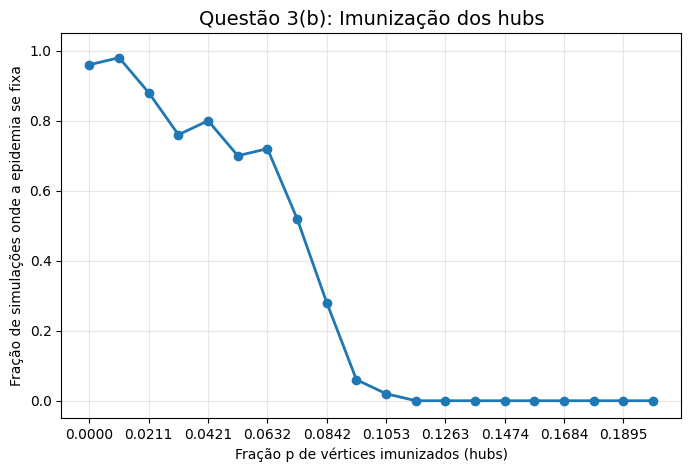

In [38]:
plt.figure(figsize=(8,5))
plt.plot(ps2, results_b, marker='o', linewidth=2)
plt.xlabel("Fração p de vértices imunizados (hubs)", fontsize=10)
plt.ylabel("Fração de simulações onde a epidemia se fixa", fontsize=10)
plt.title("Questão 3(b): Imunização dos hubs", fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(ps2[::2])
plt.ylim(-0.05, 1.05)
plt.show()

## Questão 3 - C

In [34]:
def pick_neighbors(G, p):
    """
        Seleciona uma fração p de vértices aleatórios e retorna 
        o conjunto de seus vizinhos (a serem imunizados).
        
        Parâmetros:
            G (networkx.Graph): grafo da rede.
            p (float): fração de vértices escolhidos aleatoriamente.
        
        Retorna:
            set: conjunto de vizinhos dos vértices selecionados.
    """
    N = G.number_of_nodes()
    k = int(p * N)

    seeds = random.sample(list(G.nodes()), k)
    immunized = set()

    for s in seeds:
        for nb in G.neighbors(s):
            immunized.add(nb)

    return immunized


def test_fraction_neighbors(G, p, beta, mu, runs=50):
    """
        Testa se a epidemia se fixa após imunizar os vizinhos de 
        vértices aleatórios, repetindo várias simulações.
        
        Parâmetros:
            G (networkx.Graph): grafo original.
            p (float): fração de vértices usados como "sementes" para imunizar vizinhos.
            beta (float): taxa de infecção.
            mu (float): taxa de recuperação.
            runs (int): número de simulações independentes.
        
        Retorna:
            float: fração de simulações onde a epidemia se mantém em estado endêmico.
    """
    immunized = pick_neighbors(G, p)
    
    G2 = G.copy()
    G2.remove_nodes_from(immunized)

    survives = 0
    for _ in range(runs):
        infected_init = random.sample(list(G2.nodes()), 5)
        hist = simulate_SIS(G2, beta, mu, infected_init)
        if epidemic_persists(hist):
            survives += 1

    return survives / runs


ps3 = np.linspace(0, 0.2, 20)
results_c = []

for p in tqdm(ps3):
    results_c.append(test_fraction_neighbors(G, p, beta, mu))


100%|██████████| 20/20 [01:50<00:00,  5.50s/it]


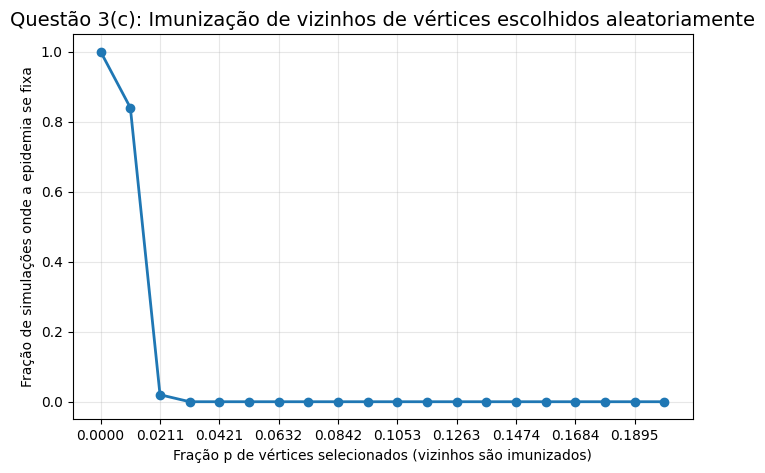

In [37]:
plt.figure(figsize=(8,5))
plt.plot(ps3, results_c, marker='o', linewidth=2)
plt.xlabel("Fração p de vértices selecionados (vizinhos são imunizados)", fontsize=10)
plt.ylabel("Fração de simulações onde a epidemia se fixa", fontsize=10)
plt.title("Questão 3(c): Imunização de vizinhos de vértices escolhidos aleatoriamente", fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(ps3[::2])
plt.ylim(-0.05, 1.05)
plt.show()


## Conclusão

Para a primeira simulação, em que escolhemos vértices aleatórios para imunizar, observamos que a epidemia continua conseguindo se fixar na maior parte das simulações. Podemos ver no gráfico que apenas para valores bem altos de **p** a doença deixa de se fixar. Isso se deve ao fato de que em redes livres de escala os hubs são de certa forma raros e sendo a imunização aleatória, quase nunca é imunizado um vértice de grau alto. Podemos concluir, que a imunização aleatória é um método ineficiente para para impedir o estado endêmico nesse tipo de rede.

Ao contrário da alternativa anterior, quando imunizamos os vértices de maior grau, podemos observar no gráfico uma queda muito rápida na capacidade da epidemia se fixar. Para um **p** pequeno já conseguimos ver a incapacidade da epidemia de se sustentar. Para algo em torno de 7%, temos o ponto em que em 50% das simulações ela se fixa e 50% não, a partir dali, logo em 10%, quebramos totalmente a estrutura que sustenta o estado endêmico. Essas simulações vão bater com a teoria das redes livre de escala que diz os hubs são os principais responsáveis pela conectividade global e, no nosso caso, pela persistência da doença, já que concentram grande parte do fluxo de contágio. Nesse tipo de rede, imunizar os hubs, se mostrou uma estratégia muito eficiente. 

Nas simulações, essa se mostrou ser a mais eficiente das três. A epidemia deixa de se fixar completamente com 2% de imunizados, despencando para zero antes do cenário B com a imunização direta dos hubs. Isso pode indicar que ao selecionar os vizinhos, podemos estar selecionando de forma indireta os vértices de maior grau e atacando os hubs. Logo, comparando os resultados, podemos afirmar que das três, essa se mostrou ser a estratégia mais eficiente para combater a fixação da epidemia. 

Por fim, os resultados confirmam o comportamento típico de redes livre de escala: elas são altamente robustas a falhas aleatórias, o que explica por que imunizar vértices aleatórios exige uma fração muito grande de vacinados. Porém, elas são extremamente frágeis a ataques direcionados, o que aparece tanto na imunização dos hubs quanto na dos vizinhos (acredito que atingiram os hubs indiretamente). Mostrando que a fração de vértices imunizados necessários para impedir que a epidemia se fixe, é drasticamente menor quando atacamos de forma estruturada ao invés de uma forma aleatória. 